In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import sklearn
import datetime
import seaborn as sns
%matplotlib inline

In [2]:
def read_csv(filepath):
     if os.path.splitext(filepath)[1] != '.csv':
          return  # or whatever
     seps = [',', ';', '\t']                    # ',' is default
     encodings = [None, 'utf-8', 'ISO-8859-1']  # None is default
     for sep in seps:
         for encoding in encodings:
              try:
                  return pd.read_csv(filepath, encoding=encoding, sep=sep)
              except Exception:  # should really be more specific 
                  pass
     raise ValueError("{!r} is has no encoding in {} or seperator in {}"
                      .format(filepath, encodings, seps))

In [3]:
df = read_csv('SCMS_Delivery_History_Dataset_20150929.csv')

# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
ID                              10324 non-null int64
Project Code                    10324 non-null object
PQ #                            10324 non-null object
PO / SO #                       10324 non-null object
ASN/DN #                        10324 non-null object
Country                         10324 non-null object
Managed By                      10324 non-null object
Fulfill Via                     10324 non-null object
Vendor INCO Term                10324 non-null object
Shipment Mode                   9964 non-null object
PQ First Sent to Client Date    10324 non-null object
PO Sent to Vendor Date          10324 non-null object
Scheduled Delivery Date         10324 non-null object
Delivered to Client Date        10324 non-null object
Delivery Recorded Date          10324 non-null object
Product Group                   10324 non-null object
Sub Classification           

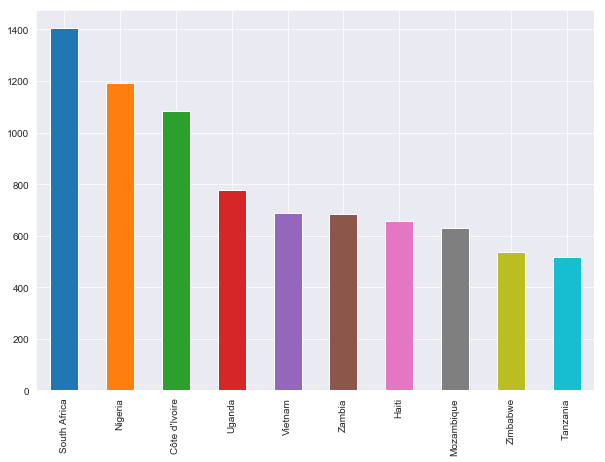

In [5]:
sns.set_style('darkgrid')
country = df['Country'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(10,7))
country.plot.bar(ax=ax)

In [6]:
df['Shipment Mode'].value_counts()

Air            6113
Truck          2830
Air Charter     650
Ocean           371
Name: Shipment Mode, dtype: int64

In [7]:
df['Fulfill Via'].value_counts()

From RDC       5404
Direct Drop    4920
Name: Fulfill Via, dtype: int64

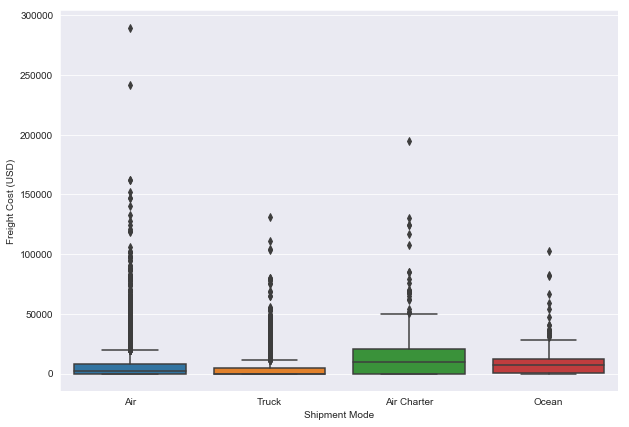

In [20]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(df['Shipment Mode'],df['Freight Cost (USD)'],ax=ax);

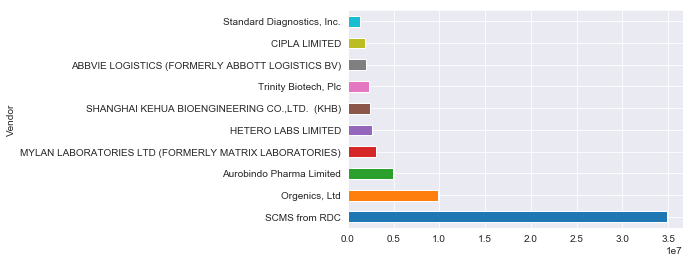

In [21]:
df.groupby('Vendor')['Freight Cost (USD)'].sum().sort_values(ascending=False).head(10).plot.barh();

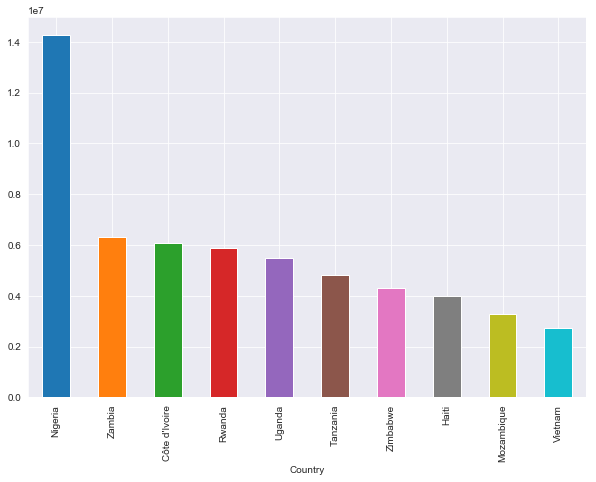

In [22]:
fig, ax = plt.subplots(figsize=(10,7))
df.groupby('Country')['Freight Cost (USD)'].sum().sort_values(ascending=False).head(10).plot.bar(ax=ax);

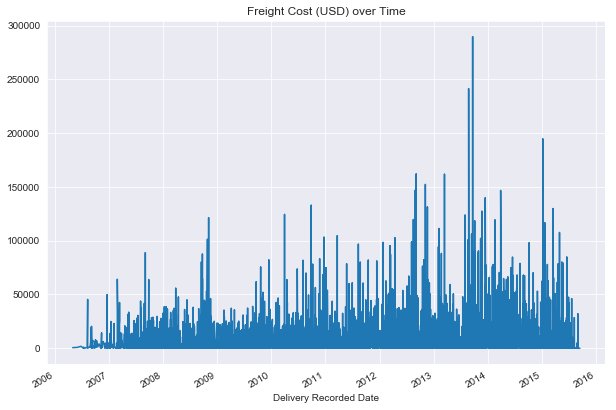

In [23]:
dt = df.set_index('Delivery Recorded Date')['Freight Cost (USD)']
fig, ax = plt.subplots(figsize=(10,7))
dt.plot(title='Freight Cost (USD) over Time');

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


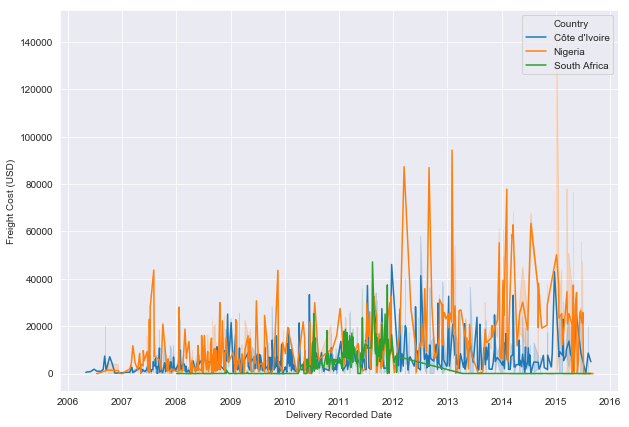

In [24]:
dtc = df[df['Country'].isin(df['Country'].value_counts().head(3).index)]
dtc = dtc.set_index('Delivery Recorded Date')[['Freight Cost (USD)','Country']]
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='Delivery Recorded Date',y='Freight Cost (USD)',data=dtc.reset_index(),hue='Country')

In [25]:
# Identify number of categorical features
for d in df.columns:
    if(df[d].dtype == 'O'):
        print(d,': ', df[d].nunique())

Project Code :  142
PQ # :  1237
PO / SO # :  6233
ASN/DN # :  7030
Country :  43
Managed By :  4
Fulfill Via :  2
Vendor INCO Term :  8
Shipment Mode :  4
Product Group :  5
Sub Classification :  6
Vendor :  73
Item Description :  184
Molecule/Test Type :  86
Brand :  48
Dosage :  54
Dosage Form :  17
Manufacturing Site :  88
First Line Designation :  2


# Data Pre-Processing

In [9]:
# Convert Date fields to DateTime data type
df['PQ First Sent to Client Date'] = pd.to_datetime(df[df['PQ First Sent to Client Date']!='NA']\
                                ['PQ First Sent to Client Date'],errors='coerce',format='%m/%d/%Y')

df['PO Sent to Vendor Date'] = pd.to_datetime(df[df['PO Sent to Vendor Date']!='NA']\
                                ['PO Sent to Vendor Date'],errors='coerce',format='%m/%d/%Y')

df['Scheduled Delivery Date'] = pd.to_datetime(df[df['Scheduled Delivery Date']!='NA']\
                                ['Scheduled Delivery Date'],errors='coerce',format='%d-%b-%y')

df['Delivered to Client Date'] = pd.to_datetime(df[df['Delivered to Client Date']!='NA']\
                                ['Delivered to Client Date'],errors='coerce',format='%d-%b-%y')

df['Delivery Recorded Date'] = pd.to_datetime(df['Delivery Recorded Date'],errors='coerce',format='%d-%b-%y')

In [10]:
# Create feature to be predicted by identifying difference between scheduled and actual delivery
df['Schedule v Actual'] = df['Scheduled Delivery Date'] - df['Delivery Recorded Date']
df['Schedule v Actual'].value_counts().head(15)

0 days     5514
-1 days     223
-3 days     133
-2 days     131
17 days     117
7 days      108
-5 days     106
-6 days     101
13 days     100
6 days       99
8 days       97
-4 days      97
2 days       94
-7 days      93
31 days      81
Name: Schedule v Actual, dtype: int64

In [11]:
# Transform Schedule v. Actual column into a categorical int value removing trailing 'days' from values
df['Schedule v Actual'] = (df['Schedule v Actual'] / np.timedelta64(1, 'D')).astype('category')

In [26]:
len(df['Scheduled Delivery Date'])

10324

In [27]:
dt = df.select_dtypes(include='datetime')

for col in dt.columns:
    df[col+' day'] = pd.DatetimeIndex(df[col]).day
    df[col+' month'] = pd.DatetimeIndex(df[col]).month
    df[col+' year'] = pd.DatetimeIndex(df[col]).year
    df.drop(col,axis=1,inplace=True)

In [28]:
# Drop columns w/o relevant info from analysis
df.drop(['ID','PO / SO #','ASN/DN #','PQ #'],axis=1,inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 40 columns):
Project Code                          10324 non-null object
Country                               10324 non-null object
Managed By                            10324 non-null object
Fulfill Via                           10324 non-null object
Vendor INCO Term                      10324 non-null object
Shipment Mode                         9964 non-null object
Product Group                         10324 non-null object
Sub Classification                    10324 non-null object
Vendor                                10324 non-null object
Item Description                      10324 non-null object
Molecule/Test Type                    10324 non-null object
Brand                                 10324 non-null object
Dosage                                8588 non-null object
Dosage Form                           10324 non-null object
Unit of Measure (Per Pack)            10324 non-null 

In [12]:
df['Weight (Kilograms)'].value_counts().head(15)

Weight Captured Separately    1507
2                               29
6                               26
1                               23
5                               20
60                              20
4                               19
3                               18
39                              17
36                              17
9                               17
14                              17
12                              17
18                              17
17                              17
Name: Weight (Kilograms), dtype: int64

In [13]:
# Set all entries with 'Weight Captured Separately' as Null
df['Weight (Kilograms)'].replace('Weight Captured Separately',0,inplace=True)

In [14]:
# Replace string values with zero
df.loc[df['Weight (Kilograms)'].str.contains('See',na=False), 'Weight (Kilograms)'] = 0

In [15]:
# Update previously transformed zero values with mean value of data
df['Weight (Kilograms)'] = df['Weight (Kilograms)'].astype('int64')
df['Weight (Kilograms)'].replace(0,df[df['Weight (Kilograms)']!=0].mean(),inplace=True)

In [16]:
df['Freight Cost (USD)'].value_counts().head(15)

Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
7445.8                                  16
13398.06                                16
See DN-304 (ID#:10589)                  16
9341.49                                 15
See ASN-31750 (ID#:19272)               14
See ASN-32231 (ID#:13648)               14
See ASN-28279 (ID#:13547)               13
7329.83                                 12
See DN-3015 (ID#:82554)                 12
25231.96                                11
1211.48                                 11
Name: Freight Cost (USD), dtype: int64

In [17]:
# Apply same transformations to freight cost feature
df['Freight Cost (USD)'].replace('Freight Included in Commodity Cost',0,inplace=True)
df['Freight Cost (USD)'].replace('Invoiced Separately',0,inplace=True)
df.loc[df['Freight Cost (USD)'].str.contains('See',na=False), 'Freight Cost (USD)'] = 0

In [18]:
df['Freight Cost (USD)'] = df['Freight Cost (USD)'].astype('float64')
df['Freight Cost (USD)'].replace(0,df[df['Freight Cost (USD)']!=0].mean(),inplace=True)

In [19]:
df['Line Item Insurance (USD)'].fillna(0,inplace=True)

In [30]:
# Identify number of categorical features
for d in df.columns:
    if(df[d].dtype == 'O'):
        print(d,': ', df[d].nunique())

df.head(15)

Project Code :  142
Country :  43
Managed By :  4
Fulfill Via :  2
Vendor INCO Term :  8
Shipment Mode :  4
Product Group :  5
Sub Classification :  6
Vendor :  73
Item Description :  184
Molecule/Test Type :  86
Brand :  48
Dosage :  54
Dosage Form :  17
Manufacturing Site :  88
First Line Designation :  2


,Project Code,Country,Managed By,Fulfill Via,Vendor INCO Term,Shipment Mode,Product Group,Sub Classification,Vendor,Item Description,...,PO Sent to Vendor Date year,Scheduled Delivery Date day,Scheduled Delivery Date month,Scheduled Delivery Date year,Delivered to Client Date day,Delivered to Client Date month,Delivered to Client Date year,Delivery Recorded Date day,Delivery Recorded Date month,Delivery Recorded Date year
0,100-CI-T01,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",...,NaN,2,6,2006,2,6,2006,2,6,2006
1,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,"Nevirapine 10mg/ml, oral suspension, Bottle, 2...",...,NaN,14,11,2006,14,11,2006,14,11,2006
2,100-CI-T01,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",...,NaN,27,8,2006,27,8,2006,27,8,2006
3,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,SUN PHARMACEUTICAL INDUSTRIES LTD (RANBAXY LAB...,"Lamivudine 150mg, tablets, 60 Tabs",...,NaN,1,9,2006,1,9,2006,1,9,2006
4,108-VN-T01,Vietnam,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",...,NaN,11,8,2006,11,8,2006,11,8,2006
5,112-NG-T01,Nigeria,PMO - US,Direct Drop,EXW,Air,ARV,Pediatric,Aurobindo Pharma Limited,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml",...,NaN,28,9,2006,28,9,2006,28,9,2006
6,110-ZM-T01,Zambia,PMO - US,Direct Drop,DDU,Air,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",...,NaN,8,1,2007,8,1,2007,8,1,2007
7,109-TZ-T01,Tanzania,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Nevirapine 200mg, tablets, 60 Tabs",...,NaN,24,11,2006,24,11,2006,24,11,2006
8,112-NG-T01,Nigeria,PMO - US,Direct Drop,EXW,Air,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",...,NaN,7,12,2006,7,12,2006,7,12,2006
9,110-ZM-T01,Zambia,PMO - US,Direct Drop,CIP,Air,ARV,Adult,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),"Lopinavir/Ritonavir 200/50mg [Aluvia], tablets...",...,2006.0,30,1,2007,30,1,2007,30,1,2007


In [31]:
# Encode categorical fields as binary 
df_obj = pd.get_dummies(df,sparse=True,columns=df.select_dtypes(include='object').columns)

In [32]:
df_obj.head()

,Unit of Measure (Per Pack),Line Item Quantity,Line Item Value,Pack Price,Unit Price,Weight (Kilograms),Freight Cost (USD),Line Item Insurance (USD),Schedule v Actual,PQ First Sent to Client Date day,...,"Manufacturing Site_Remedica, Limassol, Cyprus",Manufacturing Site_Roche Basel,Manufacturing Site_Roche Madrid,"Manufacturing Site_Standard Diagnostics, Korea","Manufacturing Site_Strides, Bangalore, India.","Manufacturing Site_Trinity Biotech, Plc","Manufacturing Site_Weifa A.S., Hausmanngt. 6, P.O. Box 9113 GrÃ¸nland, 0133, Oslo, Norway",Manufacturing Site_bioLytical Laboratories,First Line Designation_No,First Line Designation_Yes
0,30,19,551.0,29.00,0.97,13,780.34,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,240,1000,6200.0,6.20,0.03,358,4521.50,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1
2,100,500,40000.0,80.00,0.80,171,1653.78,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1
3,60,31920,127360.8,3.99,0.07,1855,16007.06,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1
4,60,38000,121600.0,3.20,0.05,7590,45450.08,0.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,1


In [33]:
nums = df_obj.select_dtypes(include = 'float64')
nums.head()

,Line Item Value,Pack Price,Unit Price,Freight Cost (USD),Line Item Insurance (USD),PQ First Sent to Client Date day,PQ First Sent to Client Date month,PQ First Sent to Client Date year,PO Sent to Vendor Date day,PO Sent to Vendor Date month,PO Sent to Vendor Date year
0,551.0,29.00,0.97,780.34,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6200.0,6.20,0.03,4521.50,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,40000.0,80.00,0.80,1653.78,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,127360.8,3.99,0.07,16007.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121600.0,3.20,0.05,45450.08,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Normalize all numerical values for better model performance
from sklearn.preprocessing import normalize

for col in nums.columns:
    df_obj[col]=(df_obj[col]-df_obj[col].min())/(df_obj[col].max()-df_obj[col].min())

In [35]:
df_obj.select_dtypes(include='float64').head()

,Line Item Value,Pack Price,Unit Price,Freight Cost (USD),Line Item Insurance (USD),PQ First Sent to Client Date day,PQ First Sent to Client Date month,PQ First Sent to Client Date year,PO Sent to Vendor Date day,PO Sent to Vendor Date month,PO Sent to Vendor Date year
0,0.000093,0.021551,0.004065,0.002694,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001042,0.004607,0.000126,0.015610,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006720,0.059451,0.003352,0.005710,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0.021398,0.002965,0.000293,0.055263,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020430,0.002378,0.000210,0.156912,0.0,NaN,NaN,NaN,NaN,NaN,NaN


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


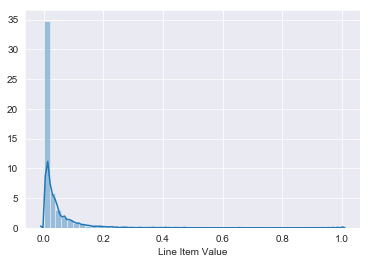

In [36]:
sns.distplot(df_obj['Line Item Value']);

In [37]:
# Apply Log + 1 transformation to normalize skewed data while accounting for zeros.
for col in nums.columns:
    df_obj[col] = np.log(df[col]+1)

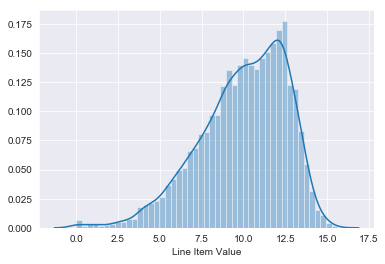

In [38]:
sns.distplot(df_obj['Line Item Value']);

# Benchmark Model Performance

In [39]:
X_bench1 = df_obj.drop('Freight Cost (USD)',axis=1)
y_bench1 = df_obj['Freight Cost (USD)']

df_obj['y_bench_pred1'] = df_obj['Freight Cost (USD)'].mean()

In [40]:
# Identify baseline scoring metrics for freight cost estimation
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_bench1, df_obj['y_bench_pred1']))
print('MSE:', metrics.mean_squared_error(y_bench1, df_obj['y_bench_pred1']))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_bench1, df_obj['y_bench_pred1'])))

MAE: 4.126897296720045
MSE: 18.70287924604892
RMSE: 4.3246825601480765


In [41]:
df_obj.drop('y_bench_pred1',axis=1,inplace=True)

In [42]:
df_obj['Schedule v Actual'].mode()

0    0.0
Name: Schedule v Actual, dtype: category
Categories (240, float64): [-469.0, -418.0, -401.0, -196.0, ..., 155.0, 167.0, 169.0, 220.0]

In [43]:
X_bench2 = df_obj.drop('Schedule v Actual',axis=1)
y_bench2 = df_obj['Schedule v Actual'].astype('category')

df_obj['y_bench_pred2'] = 0

In [44]:
print(metrics.accuracy_score(y_bench2,df_obj['y_bench_pred2']))

0.5340953118946145


In [45]:
df_obj.drop('y_bench_pred2',axis=1,inplace=True)

In [46]:
# Start modeling. (Establish pipeline for supervised models) then branch out into Deep Learning and LSTM's

# Begin Modeling Data

In [47]:
# Split data into training and test set

from sklearn.model_selection import train_test_split

X = df_obj.drop('Freight Cost (USD)',axis=1)
y = df_obj['Freight Cost (USD)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten


model = Sequential()

# The Input Layer :
model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               101120    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 134,401
Trainable params: 134,401
Non-trainable params: 0
_________________________________________________________________


In [49]:
from keras.callbacks import ModelCheckpoint

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.2, callbacks=callbacks_list,verbose=2)

Train on 5533 samples, validate on 1384 samples
Epoch 1/10


In [ ]:
wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [ ]:
# Use LSTM to forecast freight costs per month (Scrap above idea)